In [116]:
%matplotlib inline
import cmath
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [372]:
# Define certain functions
def generate_tm_vec(sigma, size):
    """Generate a single vector of a transmission matrix."""
    return (np.random.normal(loc=0.0, scale=sigma, size=size) +
        np.random.normal(loc=0.0, scale=sigma, size=size) * 1j)

def tm_vec_add_noise(tm_vec, sigma, modify_original=False):
    noise_vec = (np.random.normal(loc=0.0, scale=sigma, size=len(tm_vec)) +
                 np.random.normal(loc=0.0, scale=sigma, size=len(tm_vec)) * 1j)
    if modify_original:
        tm_vec += noise_vec
        return tm_vec
    else:
        return tm_vec + noise_vec

def tm_vec_add_phase_noise(tm_vec, scale=1.0):
    phase_vec = np.random.random_sample(len(tm_vec)) * (2.0 * np.pi * scale)
    print
    phase_mult_vec = np.cos(phase_vec) + 1j * np.sin(phase_vec)
    return tm_vec * phase_mult_vec

In [402]:
# Simulation parameters
steps_max = 10240
noise_sigma = 0.0 #5.0e-4
media_changes = False

In [403]:
# Constant variables definition
slm_side = 32
slm_size = slm_side**2                     # SLM size
slm_pattern_ref = np.ones(slm_size)        # Reference SLM pattern
e_in = 1.0 + 0.0j                          # Incident electric field vector
h_matrix = scipy.linalg.hadamard(slm_size) # Hadamard matrix
tm_vec_sigma = 1.2e-3
tm_vec = generate_tm_vec(tm_vec_sigma, slm_size)    # Vector of a medium's transittion matrix
e_ref = np.dot(tm_vec, slm_pattern_ref) * e_in
h1_indices = np.fromiter((k for k in range(0, slm_size)), dtype=int)
h_1 = h_matrix.take(indices=h1_indices)
I_1 = np.abs(np.dot(tm_vec, h_1))**2

# Normalize intensity
# tm_vec /= I_1
# I_1 = np.abs(np.dot(tm_vec, h_1))**2
# e_ref = np.dot(tm_vec, slm_pattern_ref) * e_in

align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
tm_vec = tm_vec * align_multiplier

In [404]:
# Variable values definition
slm_pattern = np.zeros(slm_size, dtype=np.float64)            # Actual SLM pattern
enh_history = np.zeros(steps_max, dtype=np.float64)
tm_vec_est = np.zeros(slm_size, dtype=np.float64)

In [405]:
# Calculate initial enhancement
samples_num = 100000
I_init = 0.0
for i in range(0, samples_num):
    tm_vec_temp = generate_tm_vec(tm_vec_sigma, slm_size)
    I_init += np.abs(np.dot(tm_vec_temp, h_1) * e_in)**2
I_init = I_init / samples_num / 2.0

Original transmission matrix (real part):
[-0.00051983  0.00145002  0.00181439 ... -0.00121738 -0.0005293
 -0.00061153]
Estimated transmission matrix (real part):
[-0.00051983  0.00145002  0.00181439 ... -0.00121738 -0.0005293
 -0.00061153]
Correct estimations: 1024/1024
Opened pixels: 527/1024
Optimal SLM pattern:


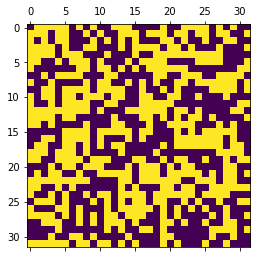

Initial intensity: 0.0014657817211028556
Optimal intensity: 0.2457505605070981
Theoretical intensity: 0.2457505605070981
Enhancement: 167.65836070202536
Fluctuating media simulation


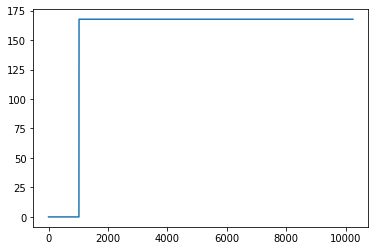

In [406]:
Re_signal = np.zeros(slm_size, dtype=np.float64)
tm_vec_est = np.zeros(slm_size, dtype=np.float64)
slm_pattern = np.zeros(slm_size, dtype=np.float64)

# Transmission matrix estimation
tm_vec_var = tm_vec.copy()
for slm_pix in range(0, slm_size):
    if noise_sigma != 0.0:
        if media_changes:
            tm_vec_var = tm_vec_add_noise(tm_vec_var, noise_sigma)
            # Normalize transmission matrix
            # tm_vec_mag_old = np.abs(np.dot(tm_vec_var, np.conjugate(tm_vec_var)))
            # tm_vec_var = tm_vec_add_noise(tm_vec_var, noise_sigma)
            # tm_vec_mag_new = np.abs(np.dot(tm_vec_var, np.conjugate(tm_vec_var)))
            # tm_vec_var *= tm_vec_mag_old / tm_vec_mag_new
        else:
            tm_vec_var = tm_vec_add_noise(tm_vec, noise_sigma)
        # Normalize intensity
        # tm_vec_var /= np.abs(np.dot(tm_vec_var, h_1))**2
    
    h_indices = np.fromiter((k + slm_pix * slm_size for k in range(0, slm_size)), dtype=int)
    h_i = h_matrix.take(indices=h_indices)
    v_plus = (h_1 + h_i) / 2.0
    v_minus = (h_1 - h_i) / 2.0
    I_plus = np.abs(np.dot(tm_vec_var, v_plus))**2
    I_minus = np.abs(np.dot(tm_vec_var, v_minus))**2
    Re_signal[slm_pix] = (I_plus - I_minus) / np.sqrt(I_1)

if not media_changes:
    tm_vec_var = tm_vec

for i in range(0, slm_size):
    h_indices = np.fromiter((k + i * slm_size for k in range(0, slm_size)), dtype=int)
    h_i = h_matrix.take(indices=h_indices)
    tm_vec_est += Re_signal[i] * h_i / slm_size

# Estimate the optimal SLM pattern
opened_pixels = 0
for i in range(0, slm_size):
    if tm_vec_est[i] >= 0.0:
        slm_pattern[i] = 1.0
        opened_pixels += 1

correct_estimations = 0
for i in range(0, slm_size):
    if np.sign(tm_vec_est[i]) == np.sign(tm_vec[i]):
        correct_estimations += 1

print("Original transmission matrix (real part):")
print(tm_vec.real)
print("Estimated transmission matrix (real part):")
print(tm_vec_est)
print("Correct estimations: {0}/{1}".format(correct_estimations, len(tm_vec)))
print("Opened pixels: {0}/{1}".format(opened_pixels, len(tm_vec)))
        
print("Optimal SLM pattern:")
plt.matshow(slm_pattern.reshape((slm_side, slm_side)))
plt.show()

I_opt = np.abs(np.dot(tm_vec_var, slm_pattern) * e_in)**2
enh = I_opt / I_init

print("Initial intensity: {0}".format(I_init))
print("Optimal intensity: {0}".format(I_opt))
print("Theoretical intensity: {0}".format(np.abs(np.dot(tm_vec, slm_pattern) * e_in)**2))
print("Enhancement: {0}".format(enh))

# Simulation of the fluctuating medium
enh_history[slm_size - 1] = enh

for i in range(slm_size, steps_max):
    if noise_sigma != 0.0:
        tm_vec_var = tm_vec_add_noise(tm_vec, noise_sigma, media_changes)
    I_opt = np.abs(np.dot(tm_vec_var, slm_pattern) * e_in)**2
    enh_history[i] = I_opt / I_init

print("Fluctuating media simulation")
plt.plot(enh_history)
plt.show()

In [255]:
# Old code below

In [182]:
# Constants
SLM_size = 1024
# Set the incident electric field vector
e_in = 1.0 + 0.0j
# Set the reference SLM pattern
a_ref = np.ones(SLM_size)
# Define a Hadamard matrix
h_matrix = scipy.linalg.hadamard(SLM_size)

In [183]:
# SLM vector
a_vec = np.ones(SLM_size)

In [184]:
# Calculate random transmission matrix
K_vec_real = np.random.normal(loc=0.0, scale=1.0, size=SLM_size)
K_vec_imaginary = np.random.normal(loc=0.0, scale=1.0, size=SLM_size)
# K_vec = K_vec_real + K_vec_imaginary * 1j
# del K_vec_real, K_vec_imaginary

In [188]:
# Calculate the reference intensity at the observation (focusing) point
K_vec = K_vec_real + K_vec_imaginary * 1j
e_ref = np.dot(K_vec, a_ref) * e_in
align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
K_vec = K_vec * align_multiplier
e_ref = np.dot(K_vec, a_ref) * e_in
i_ref = np.abs(np.dot(K_vec, a_ref) * e_in)

In [170]:
# Calculate the output electric field for all Hadamard modes
e_h_vec = np.zeros(SLM_size, dtype=np.complex128)
e_RH_vec = np.zeros(SLM_size, dtype=np.complex128)
Re_e_H_vec = np.zeros(SLM_size, dtype=np.complex128)
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_vec = h_matrix.take(indices=indices)
    e_h_vec[i] = np.dot(K_vec, h_vec) * e_in
    e_RH_vec[i] = (e_h_vec[i] + e_ref)
#     Re_e_H_vec[i] = 0.5 * np.abs(e_ref) * (
#         np.abs(e_RH_vec[i])**2 / np.abs(e_ref)**2 - np.abs(e_h_vec[i])**2 / np.abs(e_ref)**2 - 1.0)
    Re_e_H_vec[i] = 0.5 * np.abs(e_ref) * (
        np.abs(e_RH_vec[i])**2 / np.abs(e_ref)**2 - 1.0)
print("Original Re(E_H):\n{0}".format(np.real(e_h_vec)))
print("Recovered Re(E_H):\n{0}".format(np.real(Re_e_H_vec)))

Original Re(E_H):
[ 26.67127723  -1.56464577 -55.69839908 ...  33.03460797   4.32865891
 -59.34517881]
Recovered Re(E_H):
[40.00691584  7.79259854 12.68172117 ... 53.6627494  52.4385171
 91.58448005]


In [171]:
J_vec = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_vec = h_matrix.take(indices=indices)
    J_vec += np.abs(e_RH_vec[i]**2) * h_vec
print("J = {0}".format(J_vec))

A_opt = np.zeros(SLM_size, dtype=np.uint8)
for i in range(0, SLM_size):
    if J_vec[i] >= 0.0:
        A_opt[i] = 1
print("A_opt = {0}".format(A_opt))
print("Number of ones: {0}".format(np.sum(A_opt)))

J = [2893636.91774479 -115668.98815511  -79401.64135419 ...   83042.4110317
   64812.2281569  -155298.73611352]
A_opt = [1 0 0 ... 1 1 0]
Number of ones: 515


In [172]:
A_ideal = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    # print(np.angle(K_vec[i]))
    if np.angle(K_vec[i]) > -np.pi / 2.0 and np.angle(K_vec[i]) < np.pi / 2.0:
        A_ideal[i] = 1
I_ideal = np.abs(np.dot(K_vec, A_ideal) * e_in)**2
print("I_ideal = {0}".format(I_ideal))

I_ideal = 190976.86545469682


In [173]:
# Calculate optimized intensity
I_init = np.abs(np.dot(K_vec, a_ref) * e_in)**2
I_opt = np.abs(np.dot(K_vec, A_opt) * e_in)**2
print("I_opt = {0}".format(I_opt))
print("I_init = {0}".format(I_init))
print("enh = {0}".format(I_opt / I_init))

I_opt = 73587.65637049713
I_init = 711.3570289279787
enh = 103.44686757561723


In [174]:
h_matrix_tr = np.transpose(h_matrix)
e_h_vec_re = np.real(e_h_vec)
re_ke0 = np.dot(e_h_vec_re, h_matrix_tr) / SLM_size

In [175]:
print(e_ref)

(26.67127722715916+3.019806626980426e-14j)


In [176]:
# print(np.angle(e_ref))
align_multiplier = np.cos(-np.angle(e_ref))+1j * np.sin(-np.angle(e_ref))
print(align_multiplier)
print(np.angle(e_ref * align_multiplier))
print(np.angle(np.dot(K_vec * align_multiplier, a_ref) * e_in))
# print(np.dot(e_ref))

(1-1.1322317267601192e-15j)
0.0
-2.6640746512002823e-16


In [177]:
print(e_ref)

(26.67127722715916+3.019806626980426e-14j)


In [178]:
eref = 10.0 + 0.0j
eh = 1.0 + 1.0j
erh = eh + eref
re_eh = 0.5 * np.abs(eref) * (np.abs(erh)**2 / np.abs(eref)**2 - np.abs(eh)**2 / np.abs(eref)**2 - 1.0)
print(re_eh)

1.0000000000000009


In [186]:
# Calculate initial intensity
I_init_1 = 0.0
for i in range(0, 100000):
    K_vec_real_init = np.random.normal(loc=0.0, scale=1.0, size=SLM_size)
    K_vec_imaginary_init = np.random.normal(loc=0.0, scale=1.0, size=SLM_size)
    K_vec_init = K_vec_real_init + K_vec_imaginary_init * 1j
    I_init_1 += np.abs(np.dot(K_vec_init, h_1) * e_in)**2
I_init_1 /= 100000.0

In [190]:
# Second approach
h1_indices = np.fromiter((k for k in range(0, SLM_size)), dtype=int)
h_1 = h_matrix.take(indices=h1_indices)
I_1 = np.abs(np.dot(K_vec, h_1))**2
Re_signal = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_i = h_matrix.take(indices=indices)
    v_plus = (h_1 + h_i) / 2.0
    v_minus = (h_1 - h_i) / 2.0
    I_plus = np.abs(np.dot(K_vec, v_plus))**2
    I_minus = np.abs(np.dot(K_vec, v_minus))**2
    Re_signal[i] = (I_plus - I_minus) / np.sqrt(I_1)

# Estimate the real part of the transmission matrix
T_est = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_i = h_matrix.take(indices=indices)
    T_est += Re_signal[i] * h_i / SLM_size

A_est = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    if T_est[i] >= 0:
        A_est[i] = 1.0

I_init = np.abs(np.dot(K_vec, h_1) * e_in)**2
I_opt = np.abs(np.dot(K_vec, A_est) * e_in)**2
print("I_opt = {0}".format(I_opt))
print("I_init = {0}".format(I_init_1))
print("enh = {0}".format(I_opt / I_init_1))
print(K_vec.real)
print(T_est)
print(Re_signal)

I_opt = 182431.6122056215
I_init = 2043.498594460787
enh = 89.27415595006038
[-0.03350306 -0.89716231  0.03898117 ...  0.65343115 -0.86578894
  0.60665817]
[-0.03350306 -0.89716231  0.03898117 ...  0.65343115 -0.86578894
  0.60665817]
[ 26.0374333    8.26809649  30.05748599 ...  46.80052764 -41.74403207
 -25.38672962]


In [40]:
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_i = h_matrix.take(indices=indices)

In [76]:
# Second approach with transmission matrix noise
h1_indices = np.fromiter((k for k in range(0, SLM_size)), dtype=int)
h_1 = h_matrix.take(indices=h1_indices)
I_1 = np.abs(np.dot(K_vec, h_1))**2
Re_signal = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    # Generate noise vecor
    noise_real = np.random.normal(loc=0.0, scale=0.05, size=SLM_size)
    noise_imaginary = np.random.normal(loc=0.0, scale=0.05, size=SLM_size)
    noise_vec = noise_real + noise_imaginary * 1j
    
    K_vec_wnoise = K_vec + noise_vec
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_i = h_matrix.take(indices=indices)
    v_plus = (h_1 + h_i) / 2.0
    v_minus = (h_1 - h_i) / 2.0
    I_plus = np.abs(np.dot(K_vec_wnoise, v_plus))**2
    I_minus = np.abs(np.dot(K_vec_wnoise, v_minus))**2
    Re_signal[i] = (I_plus - I_minus) / np.sqrt(I_1)

# Estimate the real part of the transmission matrix
T_est = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    indices = np.fromiter((k + i * SLM_size for k in range(0, SLM_size)), dtype=int)
    h_i = h_matrix.take(indices=indices)
    T_est += Re_signal[i] * h_i / SLM_size

A_est = np.zeros(SLM_size, dtype=np.float64)
for i in range(0, SLM_size):
    if T_est[i] >= 0:
        A_est[i] = 1.0

I_init = np.abs(np.dot(K_vec, h_1) * e_in)**2
I_opt = np.abs(np.dot(K_vec_wnoise, A_est) * e_in)**2
print("I_opt = {0}".format(I_opt))
print("I_init = {0}".format(I_init_1))
print("enh = {0}".format(I_opt / I_init_1))

I_opt = 204178.82867572087
I_init = 2044.274345375679
enh = 99.87838918860895


In [107]:
np.sqrt([1+0j, 0+1j])

array([1.        +0.j        , 0.70710678+0.70710678j])

In [287]:
np.abs(np.dot(np.conjugate(tm_vec_var), tm_vec_var))

48905.99700194136

In [396]:
tm_vec_mod = tm_vec_add_phase_noise(tm_vec, scale=0.1)
tm_vec_mod_int = np.abs(np.dot(tm_vec_mod, np.conjugate(tm_vec_mod)))
print(np.abs(np.dot(tm_vec, np.conjugate(tm_vec))))
print(tm_vec_mod_int)

4.732851874207319
4.732851874207318
